# General fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np
from array import array

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


### (2) Definition of model

Consider controlled parameter range is [-1,1]

In [3]:
# True functional dependece: triangle

def mytrue(x):
    
    tri = x + (x>0.5)*(1-2*x) + (x<-0.5)*(-1-2*x)

    return tri

#
# Basic function, return function values only
# sum of terms:  1, sin(ax), cos(ax), sin(2ax), cos(2ax) ...

def myfun(x,par):

    # Scaling factor
    
    a = par[0]

    # output array
    
    val = np.zeros(x.size)

    # Constant term
    
    val = par[1]

    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

    return val

# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,par.size))

    # Scaling factor (global)
    
    a = par[0]

    # Constant term (global)
    
    val = par[1]

    der[:,1] = 1
    
    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

        der[:,ip] = np.sin(pw*a*x)
        der[:,ip+1] = np.cos(pw*a*x)
        
        der[:,0] += par[ip]*pw*x*np.cos(pw*a*x)
        der[:,0] -= par[ip+1]*pw*x*np.sin(pw*a*x)
        
    return val,der

myfunder(np.array([0.,0.25,0.5,0.75,1.]),np.array([3.1415926,0.,0.,1.]))

(array([ 1.00000000e+00,  7.07106791e-01,  2.67948966e-08, -7.07106753e-01,
        -1.00000000e+00]),
 array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00],
        [-1.76776693e-01,  1.00000000e+00,  7.07106772e-01,
          7.07106791e-01],
        [-5.00000000e-01,  1.00000000e+00,  1.00000000e+00,
          2.67948966e-08],
        [-5.30330107e-01,  1.00000000e+00,  7.07106810e-01,
         -7.07106753e-01],
        [-5.35897932e-08,  1.00000000e+00,  5.35897932e-08,
         -1.00000000e+00]]))

### (3) Generate pseudo data to fit

In [4]:
# Considered values of x

xvec = np.linspace(-0.95,0.95,19)

# Measurement precision

svec = np.linspace(0.02,0.03,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (4) Iterative fit

In [139]:
# Number of function parameters to consider  (must be even!!!)

Nfun = 4

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 3.
parini[1] = 0.1
parini[2] = 0.4

# Initial function vales

# fini,dini = myfunder(xvec,parini) 
fini = myfun(xvec,parini) 

# Initial printout

chi2ini = np.sum((yvec-fini)**2/s2vec)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [3.  0.1 0.4 0. ]
  chi^2 =   401.249   chi^2/N = 21.11837 


In [140]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.001   # Required precision (distance from minimum)

chi2min = chi2ini
parmin = parini

par = parini

parhist = []
parhist.append(par)

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    dyvec = yvec-fval
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*dyvec/s2vec)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

    # Do not try to jump directly to the maximum (lam = 0)

    C = A
    for l in range(Nfun):
        C[l,l] *= 1 + lam
        
    # Inverse of matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    chi2new = np.sum((yvec-fnew)**2/s2vec)

    # Distance to minimum (assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    print("\nIteration step ",Nit," with lambda = ",lam)
    print(" ",parnew)
    print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2new,chi2new/(xvec.size-Nfun)))
    print("  distance to minimum: ",dist)
    
    if chi2new < chi2min :
        lam /= 10
        chi2min = chi2new
        par = parnew
    else:
        lam *= 10

    parhist.append(par)


Iteration step  1  with lambda =  0.01
  [ 3.21561899e+00 -2.45831732e-03  4.10140317e-01 -7.85509877e-03]
  chi^2 =    51.486   chi^2/N =  3.43242 
  distance to minimum:  355.2766230641516

Iteration step  2  with lambda =  0.001
  [ 3.20527747 -0.00400928  0.41228623 -0.00656202]
  chi^2 =    51.032   chi^2/N =  3.40215 
  distance to minimum:  0.2672116216812196

Iteration step  3  with lambda =  0.0001
  [ 3.20548011 -0.00402137  0.41230464 -0.00659828]
  chi^2 =    51.032   chi^2/N =  3.40214 
  distance to minimum:  6.953579332216316e-05


In [141]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

# print("\n  x       y         f(x) ")
# for ix in range(xvec.size):
#     print("%6.3f  %8.5f  %8.5f " % (xvec[ix],yvec[ix],fvec[ix]))


 Fit results:

     par         sigma_p

     3.205  +/-  0.032 
    -0.004  +/-  0.006 
     0.412  +/-  0.008 
    -0.007  +/-  0.008 

 Correlation matrix

[ 1.    -0.159  0.222  0.251]
[-0.159  1.     0.137  0.016]
[0.222 0.137 1.    0.004]
[0.251 0.016 0.004 1.   ]

 chi^2 =    51.032   chi^2/Ndf =  3.40214 


### (5) Draw iterations

In [142]:
# Prepare graph

Nit+=1   # Count initial parameter values also

grxvec = np.empty(Nit)
gryvec = np.empty(Nit)

ipx=0
ipy=2

for ih in range(Nit):
    grxvec[ih] = parhist[ih][ipx]
    gryvec[ih] = parhist[ih][ipy]

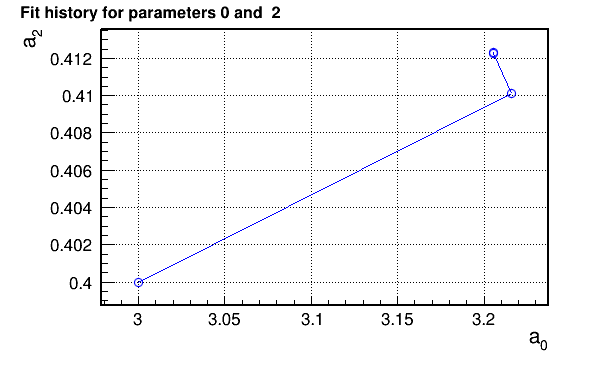

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cexp
Info in <TCanvas::Print>: png file 08_fit2_hist_4.png has been created


In [143]:
# Lin scale

gStyle.SetOptLogy(0)

# Create plot canvas

# gStyle.SetCanvasDefH(600)  # Default is 600 x 400

cexp = TCanvas('cexp')
   
## Parameter graph

pgr=TGraph(Nit,array('d',grxvec),array('d',gryvec))
pgr.SetNameTitle('pgr','Fit history for parameters '+str(ipx)+' and  '+str(ipy))
    
# Graphic style

pgr.GetXaxis().SetTitle('a_{'+str(ipx)+'}')
pgr.GetYaxis().SetTitle('a_{'+str(ipy)+'}')
pgr.SetMarkerStyle(24)
pgr.SetMarkerSize(1.0)
pgr.SetMarkerColor(4)
pgr.SetLineColor(4)
pgr.SetLineWidth(1)
pgr.SetLineStyle(1)
   
pgr.Draw('AWLP')

cexp.Update()
fname = '08_fit2_hist_'+str(Nfun)+'.png'
cexp.Print(fname)

Image(filename=fname)

### (6) Draw data and fit

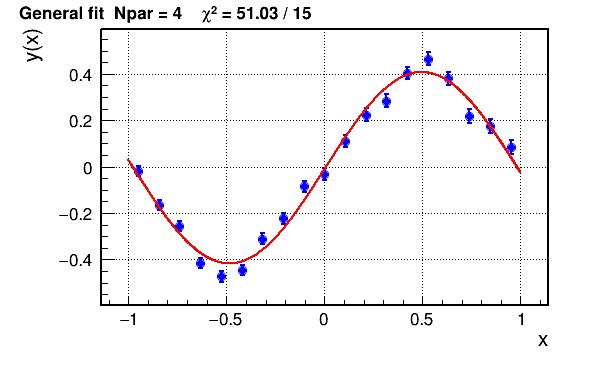

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cexp2
Info in <TCanvas::Print>: png file 08_fit2_4.png has been created


In [144]:
# Lin scale

gStyle.SetOptLogy(0)

# Create plot canvas

# gStyle.SetCanvasDefH(600)  # Default is 600 x 400

cexp2 = TCanvas('cexp2')
   
## Pseudo-data graph

dgr=TGraphErrors(xvec.size,array('d',xvec),array('d',yvec),0,array('d',svec))
dgr.SetNameTitle('dgr','General fit  Npar = '+str(Nfun)+'     #chi^{2} = '+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun))
    
# Graphic style

dgr.GetXaxis().SetTitle("x")
dgr.GetYaxis().SetTitle("y(x)")
dgr.SetMarkerStyle(20)
dgr.SetMarkerSize(1.0)
dgr.SetMarkerColor(4)
dgr.SetLineColor(4)
dgr.SetLineWidth(2)
dgr.SetLineStyle(1)
   
dgr.Draw('AWP')

# Fitted dependence wraper for root

def myfit(x, fpar):
    
    xvec = np.array([x[0]])
   
    val = myfun(xvec,par)
        
    return val[0]

# Define user function

fexp=TF1("fexp",myfit,-1.,1.,Nfun)

for ip in range(Nfun):
    fexp.SetParameter(ip,par[ip])
    
fexp.SetNpx(1000)
fexp.SetLineStyle(1)
fexp.SetLineColor(2)

# Do not draw function for Nfun=1

if Nfun>1:
    fexp.DrawCopy("Lsame")

cexp2.Update()
fname = '08_fit2_'+str(Nfun)+'.png'
cexp2.Print(fname)

Image(filename=fname)